In [2]:
import pandas as pd
from sqlite3 import connect
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
pd.set_option('mode.chained_assignment', None) # gets rid of an unhelpful SettingWithCopyWarning later on down the line.
pd.set_option("display.max_colwidth", None)

This results.csv file to be cleaned and analyzed here was compiled by Mikhail Zhilkin and is hosted at https://data.world/cervus/sumo-japan

This results.csv file lists every individual match for every wrestler on every day of every tournament between January 1983 and July 2023. My goal with this analysis project is to take this data and compile a new dataframe, one that focuses on giving a row to each individual sumo wrestler as opposed to each match outcome. This new dataframe will feature each wrestler along with the wrestler's compiled statistics (wins, losses, top rank, favorite techniques, etc.) I will later import a second CSV file (banzuke.csv), which features rows going tournament-to-tournament with information on each wrestler's height, weight, place of origin, etc. With that second spreadsheet, I will also transform that data into a new dataframe that similarly features each wrestler's compiled statistics. Once I have these two new dataframes, I will combine them into a new spreadsheet, analysis.csv, from which I will then conduct further analysis.

In [3]:
results = pd.read_csv("data/results.csv", dtype={'basho': 'string', 'day': 'string', 'rikishi1_id': 'int64', 'rikishi1_rank': 'string', 'rikishi1_shikona': 'string', 'rikishi1_result': 'string', 'rikishi1_win': 'int64', 'kimarite': 'string', 'rikishi2_id': 'int64', 'rikishi2_rank': 'string', 'rikishi2_shikona': 'string', 'rikishi2_result': 'string', 'rikishi2_win': 'string'})
results

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
0,1983.01,1,4140,J13w,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1
1,1983.01,1,4306,Ms1e,Ofuji,1-0 (6-1),1,yorikiri,4140,J13w,Chikubayama,0-1 (7-8),0
2,1983.01,1,1337,J12w,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0
3,1983.01,1,4323,J13e,Shiraiwa,0-1 (3-12),0,oshidashi,1337,J12w,Tochitsukasa,1-0 (9-6),1
4,1983.01,1,4097,J12e,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227767,2023.07,15,11985,S1w,Daieisho,9-6,0,hikiotoshi,11855,M9e,Takanosho,8-7,1
227768,2023.07,15,12451,S1e,Hoshoryu,12-3,1,uwatenage,12796,M17w,Hakuoho,11-4,0
227769,2023.07,15,12796,M17w,Hakuoho,11-4,0,uwatenage,12451,S1e,Hoshoryu,12-3,1
227770,2023.07,15,12094,K1w,Abi,6-9,1,yorikiri,12231,O1w,Kirishima,6-7-2,0


Sumo wrestlers (rikishi) in these datasets can best be identified by their unique ID numbers. Although each rikishi has his own name (shikona), some wrestlers may reuse the same name, and other wrestlers may change names during their career. Since the ID number is the one identifier that remains stable,
this is the best identifier to which I will anchor my analysis. Here I make a quick list of unique ID numbers for later use.

In [4]:
rikishi_id_list = []

for i in results["rikishi1_id"].unique():
    rikishi_id_list.append(i)

# Next to make a dictionary that holds each wrestler's unique ID number as a key, with values being each name associated with that wrestler.
# The vast majority of ID numbers will only feature one name, but this will make sure to include any additional names as well.

rikishi_id_dict = {}

# Initializes a key for every number results["rikishi1_id"] but still only adds one shikona (wrestler name) as a value per key, overwriting old shikona.
# So while this fills out the dictionary, it remains incomplete.
for i in range(len(results)):
    rikishi_id_dict.update({results["rikishi1_id"][i]: [results["rikishi1_shikona"][i]]})

# This fills out the dictionary with all associated names.
# Easy to test on rikishi_id_dict[1111], which shows both names for this wrestler, "Ama" and "Harumafuji."
# The first entry in every names list is the *most recent* name the wrestler used. So rikishi_id_dict[1111][0] shows "Harumafuji."
# This is useful to know, because when referring to a wrestler in the present day, one generally refers to them by their most current name.
# So when we reference this dictionary to indicate a wrestler's name, we will go by their most recent name, even if they have used others in the past.
for index, row in results.iterrows():
    if row["rikishi1_shikona"] not in rikishi_id_dict[row["rikishi1_id"]]:
        rikishi_id_dict[row["rikishi1_id"]].append(row["rikishi1_shikona"])

rikishi_id_dict

{4140: ['Chikubayama'],
 4306: ['Ofuji'],
 1337: ['Tochitsukasa'],
 4323: ['Shiraiwa'],
 4097: ['Tamakiyama'],
 4319: ['Harunafuji'],
 4109: ['Kotogatake'],
 4129: ['Hakuryuyama'],
 4111: ['Zaonishiki'],
 4130: ['Hachiya'],
 1302: ['Takamisugi'],
 4318: ['Tengoyama'],
 1361: ['Daitetsu'],
 4316: ['Kakureizan'],
 1385: ['Tochiakagi'],
 4125: ['Shinko'],
 1347: ['Itai'],
 4311: ['Hakuryu'],
 1332: ['Sakahoko'],
 4322: ['Sanofuji'],
 1380: ['Hidanohana'],
 4128: ['Kotochitose'],
 1350: ['Onokuni'],
 1359: ['Koboyama'],
 4087: ['Wakajishi'],
 4091: ['Washuyama'],
 1342: ['Asahifuji'],
 4103: ['Banryuyama'],
 4122: ['Kurosegawa'],
 4131: ['Tochitsurugi'],
 1348: ['Jingaku'],
 4124: ['Shishiho'],
 1334: ['Wakasegawa'],
 4118: ['Amanoyama'],
 1345: ['Tamaryu'],
 4100: ['Kaneshiro', 'Tochihikari'],
 1352: ['Tagaryu'],
 4132: ['Wakanofuji'],
 4050: ['Takamiyama'],
 4117: ['Misugiiso', 'Azumanada'],
 1378: ['Hoo'],
 4133: ['Takarakuni', 'Saisu'],
 1338: ['Ozutsu'],
 4077: ['Fujizakura'],
 1375: 

Now to creates a dataframe using this dictionary, listing each wrestler's ID with any shikona (name) associated with that wrestler. As mentioned in the previous cell, the first value in the shikona list is the most recent name the wrestler has used, which is why I'm making it the default with the column "shikona," while older names are listed as "alt_shikona."

In [5]:
shikona_df = pd.DataFrame.from_dict([([key] + value) for key, value in rikishi_id_dict.items()])
shikona_df.rename(columns={0: "id", 1: "rikishi", 2: "alt_shikona2", 3: "alt_shikona3"}, inplace=True)
shikona_df.head()

,id,rikishi,alt_shikona2,alt_shikona3
0,4140,Chikubayama,None,None
1,4306,Ofuji,None,None
2,1337,Tochitsukasa,None,None
3,4323,Shiraiwa,None,None
4,4097,Tamakiyama,None,None


There are two lines for each match in the original csv file, one for the winner and one for the loser. So as not to show duplicates of every match, we'll just show the winners with the "sumo_only_wins" list.

In [6]:
sumo_only_wins = results[results.rikishi1_win == int("1")] #could also use results.loc[results.rikishi1_win == 1]
sumo_only_wins

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
1,1983.01,1,4306,Ms1e,Ofuji,1-0 (6-1),1,yorikiri,4140,J13w,Chikubayama,0-1 (7-8),0
2,1983.01,1,1337,J12w,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0
5,1983.01,1,4319,J11w,Harunafuji,1-0 (5-10),1,yorikiri,4097,J12e,Tamakiyama,0-1 (8-7),0
7,1983.01,1,4129,J11e,Hakuryuyama,1-0 (3-12),1,tsukidashi,4109,J10w,Kotogatake,0-1 (7-8),0
9,1983.01,1,4130,J9w,Hachiya,1-0 (8-7),1,hatakikomi,4111,J10e,Zaonishiki,0-1 (4-11),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227763,2023.07,15,12270,K1e,Kotonowaka,11-4,1,yorikiri,6594,M15e,Ryuden,10-5,0
227765,2023.07,15,12291,M4e,Asanoyama,8-4-3,1,yorikiri,11980,S2w,Wakamotoharu,9-6,0
227766,2023.07,15,11855,M9e,Takanosho,8-7,1,hikiotoshi,11985,S1w,Daieisho,9-6,0
227768,2023.07,15,12451,S1e,Hoshoryu,12-3,1,uwatenage,12796,M17w,Hakuoho,11-4,0


Same as above, but now we'll just show the losers with the "sumo_only_losses" list.

In [7]:
sumo_only_losses = results[results.rikishi1_win == int("0")]
sumo_only_losses

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
0,1983.01,1,4140,J13w,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1
3,1983.01,1,4323,J13e,Shiraiwa,0-1 (3-12),0,oshidashi,1337,J12w,Tochitsukasa,1-0 (9-6),1
4,1983.01,1,4097,J12e,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1
6,1983.01,1,4109,J10w,Kotogatake,0-1 (7-8),0,tsukidashi,4129,J11e,Hakuryuyama,1-0 (3-12),1
8,1983.01,1,4111,J10e,Zaonishiki,0-1 (4-11),0,hatakikomi,4130,J9w,Hachiya,1-0 (8-7),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227762,2023.07,15,6594,M15e,Ryuden,10-5,0,yorikiri,12270,K1e,Kotonowaka,11-4,1
227764,2023.07,15,11980,S2w,Wakamotoharu,9-6,0,yorikiri,12291,M4e,Asanoyama,8-4-3,1
227767,2023.07,15,11985,S1w,Daieisho,9-6,0,hikiotoshi,11855,M9e,Takanosho,8-7,1
227769,2023.07,15,12796,M17w,Hakuoho,11-4,0,uwatenage,12451,S1e,Hoshoryu,12-3,1


For each wrestler's ID, this tallies up their total number of wins.

In [8]:
win_count = {}

for r in rikishi_id_list:
    win_count[r] = len(sumo_only_wins.loc[results.rikishi1_id == r])
    
# I now create a dataframe that sorts the win tallies from highest to lowest.
sorted_win_count = sorted(win_count.items(), key=lambda x:x[1], reverse=True)

sorted_win_count_df = pd.DataFrame.from_dict(sorted_win_count)
sorted_win_count_df.columns = ['id', 'wins']
sorted_win_count_df.head()

,id,wins
0,1123,1121
1,7,956
2,89,831
3,41,827
4,39,781


I now do the same thing but for each wrestler's total number of losses.

In [9]:
loss_count = {}

for r in rikishi_id_list:
    loss_count[r] = len(sumo_only_losses.loc[results.rikishi1_id == r])
    
sorted_loss_count = sorted(loss_count.items(), key=lambda x:x[1], reverse=True)

sorted_loss_count_df = pd.DataFrame.from_dict(sorted_loss_count)
sorted_loss_count_df.columns = ['id', 'losses']
sorted_loss_count_df.head()

,id,losses
0,41,888
1,89,869
2,33,855
3,1284,744
4,13,731


Combining the dataframe for wins the with dataframe for losses.

In [10]:
won_loss_df = pd.merge(sorted_win_count_df, sorted_loss_count_df)
won_loss_df

,id,wins,losses
0,1123,1121,212
1,7,956,642
2,89,831,869
3,41,827,888
4,39,781,692
...,...,...,...
592,11965,0,1
593,12141,0,1
594,12369,0,1
595,11949,0,2


Adding wins and losses to get the total number of matches for each wrestler.

In [11]:
matches_list = []

for i in range(len(won_loss_df)):
    matches = int(
        won_loss_df[won_loss_df.id == won_loss_df["id"][i]].wins.iloc[0]
    ) + int((won_loss_df[won_loss_df.id == won_loss_df["id"][i]].losses.iloc[0]))
    matches_list.append(matches)

won_loss_df["matches"] = matches_list
won_loss_df = won_loss_df.iloc[:, [0, 3, 1, 2]]
won_loss_df

,id,matches,wins,losses
0,1123,1333,1121,212
1,7,1598,956,642
2,89,1700,831,869
3,41,1715,827,888
4,39,1473,781,692
...,...,...,...,...
592,11965,1,0,1
593,12141,1,0,1
594,12369,1,0,1
595,11949,2,0,2


With the won-loss totals in a single dataframe, now I calculate each wrestler's winning percentage.

In [12]:
pct_list = []

for i in range(len(won_loss_df)):
    pct = round(int(won_loss_df[won_loss_df.id == won_loss_df['id'][i]].wins.iloc[0]) / int(
    (won_loss_df[won_loss_df.id == won_loss_df['id'][i]].wins.iloc[0])
    + int(won_loss_df[won_loss_df.id == won_loss_df['id'][i]].losses.iloc[0])
), 2)
    pct_list.append(pct)

won_loss_df["pct"] = pct_list
won_loss_df

,id,matches,wins,losses,pct
0,1123,1333,1121,212,0.84
1,7,1598,956,642,0.60
2,89,1700,831,869,0.49
3,41,1715,827,888,0.48
4,39,1473,781,692,0.53
...,...,...,...,...,...
592,11965,1,0,1,0.00
593,12141,1,0,1,0.00
594,12369,1,0,1,0.00
595,11949,2,0,2,0.00


This takes the won_loss_df and merges it with the shikona_df

In [13]:
new_won_loss_df = pd.merge(won_loss_df, shikona_df)
new_won_loss_df = new_won_loss_df.iloc[:, [0, 5, 1, 2, 3, 4, 6, 7]]
new_won_loss_df.head()

,id,rikishi,matches,wins,losses,pct,alt_shikona2,alt_shikona3
0,1123,Hakuho,1333,1121,212,0.84,None,None
1,7,Kaio,1598,956,642,0.60,Koga,None
2,89,Aminishiki,1700,831,869,0.49,None,None
3,41,Kyokutenho,1715,827,888,0.48,None,None
4,39,Wakanosato,1473,781,692,0.53,Kogawa,None


In the section that follows, I will determine the highest rank each wrestler has achieved during the timeframe of this project. To begin with, I have created the following data dictionary that explains the ranking system of the Japan Sumo Association.

In [14]:
sumo_ranks_data_dict = {
    "yokozuna": "The highest rank in the top Makuuchi division of sumo. Promotion to this rank is only bestowed upon special consideration. Wrestlers at this rank can never be demoted.",
    "ozeki": "The second-highest rank, though it used to be the highest before the yokozuna title came into use. Promotion to ozeki is also not automatic, and demotion requires a multi-step process.",
    "sekiwake": "The third-highest rank, and the top rank that a wrestler can conceivably achieve through a consistent winning record.",
    "komusubi": "The fourth-highest rank, the lowest of the san'yaku titleholder ranks.",
    "maegashira": "After the higher san'yaku ranks, the rest of the top makuuchi division features the maegashira ranks. The highest is maegashira-1, followed by maegashira-2, maegashira-3, etc.",
    "juryo": "The second division of sumo, fixed at 28 wrestlers. Wrestlers in this division are ranked from the top starting at juryo-1.",
    "makushita": "The third-highest division, with 120 wrestlers. Rankings go down from from the top starting at makushita-1.",
    "sandanme": "The fourth-highest division. Wrestlers in this division are ranked from the top starting at sandanme-1.",
    "jonidan": "The fifth-highest division of sumo, with wrestlers ranked from the top starting at jonidan-1.",
    "jonokuchi": "The lowest division, the entry point for all wrestlers except for amateurs with  dispensation to enter at a higher rank. Wrestlers are ranked starting from jonokuchi-1.",
}

sumo_ranks_data_dict_df = pd.DataFrame.from_dict(sumo_ranks_data_dict, orient="index")
sumo_ranks_data_dict_df = sumo_ranks_data_dict_df.reset_index()
sumo_ranks_data_dict_df.columns = ["rank", "definition"]
sumo_ranks_data_dict_df = sumo_ranks_data_dict_df.style.set_properties(
    **{"text-align": "left"}
)
sumo_ranks_data_dict_df

,rank,definition
0,yokozuna,The highest rank in the top Makuuchi division of sumo. Promotion to this rank is only bestowed upon special consideration. Wrestlers at this rank can never be demoted.
1,ozeki,"The second-highest rank, though it used to be the highest before the yokozuna title came into use. Promotion to ozeki is also not automatic, and demotion requires a multi-step process."
2,sekiwake,"The third-highest rank, and the top rank that a wrestler can conceivably achieve through a consistent winning record."
3,komusubi,"The fourth-highest rank, the lowest of the san'yaku titleholder ranks."
4,maegashira,"After the higher san'yaku ranks, the rest of the top makuuchi division features the maegashira ranks. The highest is maegashira-1, followed by maegashira-2, maegashira-3, etc."
5,juryo,"The second division of sumo, fixed at 28 wrestlers. Wrestlers in this division are ranked from the top starting at juryo-1."
6,makushita,"The third-highest division, with 120 wrestlers. Rankings go down from from the top starting at makushita-1."
7,sandanme,The fourth-highest division. Wrestlers in this division are ranked from the top starting at sandanme-1.
8,jonidan,"The fifth-highest division of sumo, with wrestlers ranked from the top starting at jonidan-1."
9,jonokuchi,"The lowest division, the entry point for all wrestlers except for amateurs with dispensation to enter at a higher rank. Wrestlers are ranked starting from jonokuchi-1."


The information in rikishi1_rank includes a designation of "e" or "w" ("east" or "west" on the banzuke [ranking chart]), but as that is immaterial to ranking, we can strip it out. A simple excision of the final character doesn't work, so I can't do the following: results.rikishi1_rank.str[:-1] See, some rankings appear on the spreadsheet with an "HD" at the end, so I have to work with a list of characters to remove in order to clean this up.

In [15]:
char_to_remove = ["e", "w", "HD", "YO"]
cleaned_rankings = results["rikishi1_rank"]
for character in char_to_remove:
    cleaned_rankings = cleaned_rankings.str.replace(character, "")

results_cleaned_rank_temp_dict = {}
results_cleaned_rank = results
results_cleaned_rank["rikishi1_rank"] = cleaned_rankings

for i in results_cleaned_rank["rikishi1_rank"]:
    if i.startswith("Ms"):
        updated_rank = i.replace("Ms", "Makushita-")
    elif i.startswith("J"):
        updated_rank = i.replace("J", "Juryo-")
    elif i.startswith("M") and not i.startswith("Makushita"):
        updated_rank = i.replace("M", "Maegashira-")
    elif i.startswith("Y"):
        updated_rank = "Yokozuna"
    elif i.startswith("O"):
        updated_rank = "Ozeki"
    elif i.startswith("S"):
        updated_rank = "Sekiwake"
    elif i.startswith("K"):
        updated_rank = "Komusubi"
    else:
        i = "none"
    results_cleaned_rank_temp_dict[i] = updated_rank

results_cleaned_rank = results_cleaned_rank.replace({"rikishi1_rank": results_cleaned_rank_temp_dict})
results_cleaned_rank.head()

,basho,day,rikishi1_id,rikishi1_rank,rikishi1_shikona,rikishi1_result,rikishi1_win,kimarite,rikishi2_id,rikishi2_rank,rikishi2_shikona,rikishi2_result,rikishi2_win
0,1983.01,1,4140,Juryo-13,Chikubayama,0-1 (7-8),0,yorikiri,4306,Ms1e,Ofuji,1-0 (6-1),1
1,1983.01,1,4306,Makushita-1,Ofuji,1-0 (6-1),1,yorikiri,4140,J13w,Chikubayama,0-1 (7-8),0
2,1983.01,1,1337,Juryo-12,Tochitsukasa,1-0 (9-6),1,oshidashi,4323,J13e,Shiraiwa,0-1 (3-12),0
3,1983.01,1,4323,Juryo-13,Shiraiwa,0-1 (3-12),0,oshidashi,1337,J12w,Tochitsukasa,1-0 (9-6),1
4,1983.01,1,4097,Juryo-12,Tamakiyama,0-1 (8-7),0,yorikiri,4319,J11w,Harunafuji,1-0 (5-10),1


Here I want to create a dictionary that lists each wrestler by ID number as a key, and the value for that key is a list of each rank that wrestler had during the top-division matches covered by the data. Obviously, each wrestler had a career in the lower ranks before reaching the top division in the first place, and that is not reflected here. However, the main goal with this is to eventually determine the best rank for every top-divsion wrestler, so the focus will eventually be on the higher ranks anyway.

In [16]:
rank_dict = {}
rank_list = []

for r in rikishi_id_list:
    for i in results_cleaned_rank.loc[results_cleaned_rank.rikishi1_id == r]["rikishi1_rank"].unique(): # Repetitions of a rank won't be necessary, thus unique() is sufficient.
        rank_list.append(i)
        rank_list
    rank_dict[r] = rank_list
    rank_list = []

This next section trims down each list of ranks that a wrestler has had, keeping only the highest rank. So the value of the dictionary key, which includes a list of multiple ranks, is now converted into a list with a single entry, that of the highest rank achieved. I originally wanted this loop to get rid of the list completely, but that caused problems with exact matching between an element in a list using "in value" and non-exact matching using the same "in value" when the item had been converted into a string. The only way I found to prevent this kind of erroneous overriding was to keep the adjusted value as a list.

In [17]:
rank_dict_temp = {}

for key, value in rank_dict.items():
    for rikishi_id in rank_dict.values():
        if "Yokozuna" in value:
            value = ["Yokozuna"]
        elif "Ozeki" in value:
            value = ["Ozeki"]
        elif "Sekiwake" in value:
            value = ["Sekiwake"]
        elif "Komusubi" in value:
            value = ["Komusubi"]
        elif "Maegashira-1" in value:
            value = ["Maegashira-1"]
        elif "Maegashira-2" in value:
            value = ["Maegashira-2"]
        elif "Maegashira-3" in value:
            value = ["Maegashira-3"]
        elif "Maegashira-4" in value:
            value = ["Maegashira-4"]
        elif "Maegashira-5" in value:
            value = ["Maegashira-5"]
        elif "Maegashira-6" in value:
            value = ["Maegashira-6"]
        elif "Maegashira-7" in value:
            value = ["Maegashira-7"]
        elif "Maegashira-8" in value:
            value = ["Maegashira-8"]
        elif "Maegashira-9" in value:
            value = ["Maegashira-9"]
        elif "Maegashira-10" in value:
            value = ["Maegashira-10"]
        elif "Maegashira-11" in value:
            value = ["Maegashira-11"]
        elif "Maegashira-12" in value:
            value = ["Maegashira-12"]
        elif "Maegashira-13" in value:
            value = ["Maegashira-13"]
        elif "Maegashira-14" in value:
            value = ["Maegashira-14"]
        elif "Maegashira-15" in value:
            value = ["Maegashira-15"]
        elif "Maegashira-16" in value:
            value = ["Maegashira-16"]
        elif "Maegashira-17" in value:
            value = ["Maegashira-17"]
        elif "Maegashira-18" in value:
            value = ["Maegashira-18"]
        elif "Maegashira-19" in value:
            value = ["Maegashira-19"]
        elif "Maegashira-20" in value:
            value = ["Maegashira-20"]
        elif "Maegashira-21" in value:
            value = ["Maegashira-21"]
        elif "Maegashira-22" in value:
            value = ["Maegashira-22"]
        elif "Maegashira-23" in value:
            value = ["Maegashira-23"]
        elif "Maegashira-24" in value:
            value = ["Maegashira-24"]
        elif "Maegashira-25" in value:
            value = ["Maegashira-25"]
        elif "Maegashira-26" in value:
            value = ["Maegashira-26"]
        elif "Maegashira-27" in value:
            value = ["Maegashira-27"]
        elif "Maegashira-28" in value:
            value = ["Maegashira-28"]
        elif "Maegashira-29" in value:
            value = ["Maegashira-29"]
        elif "Maegashira-30" in value:
            value = ["Maegashira-30"]
        elif "Juryo-1" in value:
            value = ["Juryo-1"]
        elif "Juryo-2" in value:
            value = ["Juryo-2"]
        elif "Juryo-3" in value:
            value = ["Juryo-3"]
        elif "Juryo-4" in value:
            value = ["Juryo-4"]
        elif "Juryo-5" in value:
            value = ["Juryo-5"]
        elif "Juryo-6" in value:
            value = ["Juryo-6"]
        elif "Juryo-7" in value:
            value = ["Juryo-7"]
        elif "Juryo-8" in value:
            value = ["Juryo-8"]
        elif "Juryo-9" in value:
            value = ["Juryo-9"]
        elif "Juryo-10" in value:
            value = ["Juryo-10"]
        elif "Juryo-11" in value:
            value = ["Juryo-11"]
        elif "Juryo-12" in value:
            value = ["Juryo-12"]
        elif "Juryo-13" in value:
            value = ["Juryo-13"]
        elif "Juryo-14" in value:
            value = ["Juryo-14"]
        elif "Juryo-15" in value:
            value = ["Juryo-15"]
        elif "Juryo-16" in value:
            value = ["Juryo-16"]
        elif "Juryo-17" in value:
            value = ["Juryo-17"]
        elif "Juryo-18" in value:
            value = ["Juryo-18"]
        elif "Juryo-19" in value:
            value = ["Juryo-19"]
        elif "Juryo-20" in value:
            value = ["Juryo-20"]
        elif "Juryo-21" in value:
            value = ["Juryo-21"]
        elif "Juryo-22" in value:
            value = ["Juryo-22"]
        elif "Juryo-23" in value:
            value = ["Juryo-23"]
        elif "Juryo-24" in value:
            value = ["Juryo-24"]
        elif "Juryo-25" in value:
            value = ["Juryo-25"]
        elif "Juryo-26" in value:
            value = ["Juryo-26"]
        elif "Juryo-27" in value:
            value = ["Juryo-27"]
        elif "Juryo-28" in value:
            value = ["Juryo-28"]
        elif "Juryo-29" in value:
            value = ["Juryo-29"]
        elif "Juryo-30" in value:
            value = ["Juryo-30"]
        elif "Makushita-1" in value:
            value = ["Makushita-1"]
        elif "Makushita-2" in value:
            value = ["Makushita-2"]
        elif "Makushita-3" in value:
            value = ["Makushita-3"]
        elif "Makushita-4" in value:
            value = ["Makushita-4"]
        elif "Makushita-5" in value:
            value = ["Makushita-5"]
        elif "Makushita-6" in value:
            value = ["Makushita-6"]
        elif "Makushita-7" in value:
            value = ["Makushita-7"]
        elif "Makushita-8" in value:
            value = ["Makushita-8"]
        elif "Makushita-9" in value:
            value = ["Makushita-9"]
        elif "Makushita-10" in value:
            value = ["Makushita-10"]
        elif "Makushita-11" in value:
            value = ["Makushita-11"]
        elif "Makushita-12" in value:
            value = ["Makushita-12"]
        elif "Makushita-13" in value:
            value = ["Makushita-13"]
        elif "Makushita-14" in value:
            value = ["Makushita-14"]
        elif "Makushita-15" in value:
            value = ["Makushita-15"]
        elif "Makushita-16" in value:
            value = ["Makushita-16"]
        elif "Makushita-17" in value:
            value = ["Makushita-17"]
        elif "Makushita-18" in value:
            value = ["Makushita-18"]
        elif "Makushita-19" in value:
            value = ["Makushita-19"]
        elif "Makushita-20" in value:
            value = ["Makushita-20"]
        elif "Makushita-21" in value:
            value = ["Makushita-21"]
        elif "Makushita-22" in value:
            value = ["Makushita-22"]
        elif "Makushita-23" in value:
            value = ["Makushita-23"]
        elif "Makushita-24" in value:
            value = ["Makushita-24"]
        elif "Makushita-25" in value:
            value = ["Makushita-25"]
        elif "Makushita-26" in value:
            value = ["Makushita-26"]
        elif "Makushita-27" in value:
            value = ["Makushita-27"]
        elif "Makushita-28" in value:
            value = ["Makushita-28"]
        elif "Makushita-29" in value:
            value = ["Makushita-29"]
        elif "Makushita-30" in value:
            value = ["Makushita-30"]
    rank_dict_temp[key] = value

# In what follows, I create a dictionary that features a wrestler's ID as key and top rank as value, this value cleaned up to be a string instead of a list.
# However, in the next cell, I figured out a way to work with rank_dict_temp, so this new dictionary is not neccessary. Still, I'm leaving the code here
# in case I need to reference it in the future.

# top_rank_dict = {}
# for key, value in rank_dict_temp.items():
#     value_to_string = value[0]
#     top_rank_dict[key] = value_to_string

# This creates a dataframe with each wrestler's ID as well as the top rank achieved by that wrestler.
top_rank_df = pd.DataFrame.from_dict(rank_dict_temp, orient="index")
top_rank_df = top_rank_df.reset_index()
top_rank_df.columns = ["id", "top_rank"]
top_rank_df

,id,top_rank
0,4140,Maegashira-13
1,4306,Juryo-7
2,1337,Sekiwake
3,4323,Juryo-7
4,4097,Juryo-11
...,...,...
592,12688,Maegashira-13
593,12796,Maegashira-17
594,12516,Juryo-2
595,12013,Juryo-3


Next step is to merge the dataframe with the top rank to the main won-loss dataframe.

In [18]:
new_won_loss_df = pd.merge(new_won_loss_df, top_rank_df)
new_won_loss_df = new_won_loss_df.iloc[:, [0, 1, 2, 3, 4, 5, 8, 6, 7]]
new_won_loss_df

,id,rikishi,matches,wins,losses,pct,top_rank,alt_shikona2,alt_shikona3
0,1123,Hakuho,1333,1121,212,0.84,Yokozuna,None,None
1,7,Kaio,1598,956,642,0.60,Ozeki,Koga,None
2,89,Aminishiki,1700,831,869,0.49,Sekiwake,None,None
3,41,Kyokutenho,1715,827,888,0.48,Sekiwake,None,None
4,39,Wakanosato,1473,781,692,0.53,Sekiwake,Kogawa,None
...,...,...,...,...,...,...,...,...,...
592,11965,Tochimaru,1,0,1,0.00,Makushita-3,None,None
593,12141,Shiba,1,0,1,0.00,Makushita-5,None,None
594,12369,Murata,1,0,1,0.00,Makushita-1,None,None
595,11949,Kotodaigo,2,0,2,0.00,Makushita-2,None,None


I now try to determine each wrestler's most frequently used kimarite (finishing move in a victorious match). I approach this similarly to how I determined the top rank, starting with creating a dictionary in which each wrestler's ID is the key and all that wrestler's kimarite exist as a list in the key's value. The sumo_only_wins dataframe is used to get this information, since naturally I only want to look at the kimarite that is used when the wrestler actually wins, as opposed to the results dataframe that includes both wins and losses.

In [19]:
kimarite_dict = {}
kimarite_list = []

for r in rikishi_id_list:
    for i in sumo_only_wins[sumo_only_wins.rikishi1_id == r]["kimarite"]: # The sumo_only_wins dataframe is essential!
        kimarite_list.append(i)
    if kimarite_list == []:
        kimarite_list.append('none') # Wrestlers who have never won a match will have an empty list, so "none" is added here. 
        # kimarite_dict[8901] is an example of a wrestler with no wins and therefore no kimarite.
    kimarite_dict[r] = kimarite_list
    kimarite_list = []

Now that we have a dictionary will all kimarite for every wrestler, this next step determines each wrestler's most frequently used kimarite. This information is added to favored_kimarite_dict and then coverted into a dataframe.

In [20]:
def most_frequent(list):
    return max(set(list), key=list.count)

favored_kimarite_dict = {}
for r in rikishi_id_list:
    favored_kimarite_dict[r] = most_frequent(kimarite_dict[r])

favored_kimarite_df = pd.DataFrame(favored_kimarite_dict.items(), columns=["id", "favored_kimarite"])

# Then this new dataframe is merged with our main dataframe.
results_cleaned = pd.merge(new_won_loss_df, favored_kimarite_df)
results_cleaned = results_cleaned.iloc[:, [0, 1, 2, 3, 4, 5, 6, 9, 7, 8]]

results_cleaned.head()

,id,rikishi,matches,wins,losses,pct,top_rank,favored_kimarite,alt_shikona2,alt_shikona3
0,1123,Hakuho,1333,1121,212,0.84,Yokozuna,yorikiri,None,None
1,7,Kaio,1598,956,642,0.60,Ozeki,yorikiri,Koga,None
2,89,Aminishiki,1700,831,869,0.49,Sekiwake,yorikiri,None,None
3,41,Kyokutenho,1715,827,888,0.48,Sekiwake,yorikiri,None,None
4,39,Wakanosato,1473,781,692,0.53,Sekiwake,yorikiri,Kogawa,None


That completes the cleanup of the first imported CSV file. Now I will move on the the next file, "banzuke.csv," which features a line for every wrestler in every tournament during the covered time period. What this file brings to the table is biographical data, some of which is constant over a wrestler's career (such as birth date), and some of which changes from tournament to tournament (such as weight). My plan is to clean this up into a new dataframe and merge it with the dataframe I just finished preparing.

In [21]:
banzuke = pd.read_csv("data/banzuke.csv", dtype={'basho': 'string', 'id': 'int64', 'rank': 'string', 'rikishi': 'string', 'heya': 'string', 'susshin': 'string', 'birth_date': 'string', 'height': 'float64', 'weight': 'float64', 'birth_date': 'string', 'prev': 'string', 'prev_w': 'float64', 'prev_l': 'float64'})
banzuke = banzuke.drop (['prev', 'prev_w', 'prev_l'], axis=1) # I don't need these columns for the final analysis.
banzuke = banzuke.drop (['rank', 'rikishi'], axis=1) # These are important columns, but they are shared with results.csv and are being cleaned up with that file. 
banzuke

,basho,id,heya,shusshin,birth_date,height,weight
0,1983.01,1354,Kokonoe,Hokkaido,1955-06-01,182.0,116.0
1,1983.01,4080,Mihogaseki,Hokkaido,1953-05-16,179.0,165.0
2,1983.01,4095,Futagoyama,Aomori,1953-04-03,186.0,133.0
3,1983.01,4104,Futagoyama,Aomori,1952-09-29,181.0,144.0
4,1983.01,4112,Sadogatake,Mie,1957-04-26,183.0,163.0
...,...,...,...,...,...,...,...
177873,2023.09,12833,Onoe,Okinawa,2000-05-16,180.0,175.0
177874,2023.09,12734,Shikihide,Ibaraki,2006-08-15,180.0,115.0
177875,2023.09,12631,Sakaigawa,Chiba,2005-01-05,168.0,128.0
177876,2023.09,2905,Kise,Kumamoto,1988-01-27,172.0,113.0


I already worked on the rank and rikishi/shikona (wrestler/ring name) information in the first dataframe, so I will now start the cleanup of banzuke.csv by addressing the shusshin (home country/prefecture) column. These steps are similar to the method wherein I tied ID numbers to shikona earlier.

In [22]:
rikishi_shusshin_list = []

for i in banzuke["shusshin"].unique():
    rikishi_shusshin_list.append(i)

# Next to make a dictionary that holds each wrestler's unique ID number as a key, with values being each shusshin associated with that wrestler.
# The vast majority of ID numbers will only feature one shusshin, but this will make sure to include any additional shusshin entries as well.

rikishi_shusshin_dict = {}

# The following code initializes a key for every number banzuke["id"] but still only adds one shusshin as a value per key, overwriting old shusshin.
# Earlier, when I was trying to discover all the shikona (ring names) for each wrestler, it was important to preserve all the older names. That is different from what
# I want to accomplish with the shusshin entries. Most wrestlers don't change their shusshin, but a few of them do, ostensibly from moving from one prefecture in
# Japan to another. (Wrestlers from abroad still seem to keep their original countries as shusshin, even when becoming Japanese citizens.)
# Unlike with the shikona, I'm not going to completely fill out this dictionary will all shusshin for any given wrestler. Just a wrestler's current shusshin will
# be sufficient for analysis purposes.

for i in range(len(banzuke)):
    rikishi_shusshin_dict.update({banzuke["id"][i]: [banzuke["shusshin"][i]]})

# Now I turn this into a new dataframe.
shusshin_df = pd.DataFrame.from_dict(
    [([key] + value) for key, value in rikishi_shusshin_dict.items()]
)
shusshin_df.rename(columns={0: "id", 1: "shusshin"}, inplace=True)

shusshin_df.head()

,id,shusshin
0,1354,Hokkaido
1,4080,Hokkaido
2,4095,Aomori
3,4104,Aomori
4,4112,Mie


I now do the same thing with heya (sumo stable) as I did with shusshin.

In [23]:
rikishi_heya_list = []

for i in banzuke["heya"].unique():
    rikishi_heya_list.append(i)

# Next to make a dictionary that holds each wrestler's unique ID number as a key, with values being each heya associated with that wrestler.
# The vast majority of ID numbers will only feature one heya, but this will make sure to include any additional heya entries as well.

rikishi_heya_dict = {}

for i in range(len(banzuke)):
    rikishi_heya_dict.update({banzuke["id"][i]: [banzuke["heya"][i]]})  # This overwrites old entries, so only the most current heya information is retained.

# If I wanted to show all the different heya each wrestler had ever belonged to, I would add the following deactivated code.
# But, as with shusshin,this analysis is only concerned with the most recent heya to which each wrestler has belonged, which ends up being the current heya,
# or, in the case of retired wrestlers, the heya in which they were most recently involved.

# for index, row in banzuke.iterrows():
#     if row["heya"] not in rikishi_heya_dict[row["id"]]:
#         rikishi_heya_dict[row["id"]].append(row["heya"])

heya_df = pd.DataFrame.from_dict([([key] + value) for key, value in rikishi_heya_dict.items()])
heya_df.rename(columns={0: "id", 1: "heya"}, inplace=True)
heya_df.head()

,id,heya
0,1354,Kokonoe
1,4080,Mihogaseki
2,4095,Futagoyama
3,4104,Futagoyama
4,4112,Sadogatake


Next to make a dataframe for height. As with heya, I am only concerned with the most recent entry for height, which is why I am not populating the dictionary with all values associated with each wrestler's height. I imagine most wrestlers in the top division, having been wrestling for years, are adults with heights that do not fluctuate much, if at all.

In [24]:
rikishi_height_list = []

for i in banzuke["height"].unique():
    rikishi_height_list.append(i)

rikishi_height_dict = {}

for i in range(len(banzuke)):
    rikishi_height_dict.update({banzuke["id"][i]: [banzuke["height"][i]]})

# Since there are some wrestlers who do not have a height listed, I want to convert the "not a number" entries to zero. Using height_dict_temp, I do this below.
height_dict_temp = {}
for key, value in rikishi_height_dict.items():
    if math.isnan(value[0]):
        value = [0]
    height_dict_temp[key] = value
rikishi_height_dict = height_dict_temp # Merging the temporary dictionary back with the main rikishi_height_dict, now with 0 instead of "not a number."

# Putting this into a dataframe.
height_df = pd.DataFrame.from_dict([([key] + value) for key, value in rikishi_height_dict.items()])
height_df.rename(columns={0: "id", 1: "height"}, inplace=True)
height_df.head()

,id,height
0,1354,183.0
1,4080,179.0
2,4095,186.0
3,4104,181.5
4,4112,183.5


I use the same approach to make a dataframe with each wrestler's weight. Unlike with some of the other columns, I want to make sure to capture each different weight a wrestler has been listed at across various tournaments. After filling out a dictionary with all the weights for a wrestler, my aim is to end up with an "average weight."

In [25]:
rikishi_weight_list = []

for i in banzuke["weight"]: # because I want an average of all weights each wrester has been listed at during these tournaments, I do not want to use .unique() here.
    rikishi_weight_list.append(i)

rikishi_weight_dict = {}

for i in range(len(banzuke)):
    rikishi_weight_dict.update({banzuke["id"][i]: [banzuke["weight"][i]]})

for index, row in banzuke.iterrows():
    if row["weight"] not in rikishi_weight_dict[row["id"]]:
        rikishi_weight_dict[row["id"]].append(row["weight"])

# Now that I have a dictionary listing each wrestler's ID with the differing weights that wrestler had during tournaments, now I want to create a dictionary
# that features an average of all those weights.

def average_weight(weight_list):
    return round(sum(weight_list) / len(weight_list), 1)

average_weight_dict = {}

for key, value in rikishi_weight_dict.items():
    if average_weight(value) > 0: 
        value = [average_weight(value)]
    else:
        value = [0] # There are some wrestlers who don't have an average weight because they have no entries in the "weight" column. I will mark null entries as "0".
    average_weight_dict[key] = value

# Now I turn this average weight into a new dataframe.
weight_df = pd.DataFrame.from_dict([([key] + value) for key, value in average_weight_dict.items()])
weight_df.rename(columns={0: "id", 1: "avg_weight"}, inplace=True)
weight_df.head()

,id,avg_weight
0,1354,121.3
1,4080,167.0
2,4095,133.0
3,4104,150.6
4,4112,168.2


For the sake of completeness, I am going to clean up the birth_date column. I assume each wrestler has only a single entry for birth_date, but theoretically I can see a situation in which a wrestler is listed with an incorrect birth_date that was later revised. So to prevent any possible errors, I am cleaning things up here.

In [26]:
rikishi_birth_date_list = []

for i in banzuke["birth_date"].unique():
    rikishi_birth_date_list.append(i)

rikishi_birth_date_dict = {}

for i in range(len(banzuke)):
    rikishi_birth_date_dict.update({banzuke["id"][i]: [banzuke["birth_date"][i]]})
rikishi_birth_date_dict
birth_date_df = pd.DataFrame.from_dict([([key] + value) for key, value in rikishi_birth_date_dict.items()])
birth_date_df.rename(columns={0: "id", 1: "birth_date"}, inplace=True)
# ID 7806 has no listed birth_date birth_date_df.loc[birth_date_df['id']==7806]

birth_date_df.head()

,id,birth_date
0,1354,1955-06-01
1,4080,1953-05-16
2,4095,1953-04-03
3,4104,1952-09-29
4,4112,1957-04-26


As I now have a dataframes for shusshin, heya, height, weight, and birth-date, I can drop them from the dataframe made from the original "banzuke" CSV file. With this new "banzuke_cleaned" dataframe, I can then merge each of the new dataframes – for shusshin, heya, height, and weight – together. The number of rows in "banzuke_cleaned" matches the number of rows in the original "banzuke" CSV file, which means that no rows have been accidentally left off during the cleanup process. 

In [27]:
banzuke_cleaned = banzuke.drop(["shusshin", "heya", "height", "weight", "birth_date"], axis=1)
banzuke_cleaned = pd.merge(banzuke_cleaned, shusshin_df)
banzuke_cleaned = pd.merge(banzuke_cleaned, heya_df)
banzuke_cleaned = pd.merge(banzuke_cleaned, height_df)
banzuke_cleaned = pd.merge(banzuke_cleaned, weight_df)
banzuke_cleaned = pd.merge(banzuke_cleaned, birth_date_df)
banzuke_cleaned

,basho,id,shusshin,heya,height,avg_weight,birth_date
0,1983.01,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01
1,1983.03,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01
2,1983.05,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01
3,1983.07,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01
4,1983.09,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01
...,...,...,...,...,...,...,...
177873,2023.07,12838,Niigata,Naruto,183.0,125.0,2005-03-13
177874,2023.07,12837,Tokyo,Sadogatake,178.0,126.0,2008-02-04
177875,2023.09,12837,Tokyo,Sadogatake,178.0,126.0,2008-02-04
177876,2023.07,12835,Tokyo,Arashio,177.0,114.0,2001-02-10


Knowing a wrestler's height and weight allows for calculation of body mass index (BMI). This takes each wrestler's current height along with an average of the wrestler's weight, resulting in an average BMI as opposed to a BMI at any one particular moment.

In [28]:
bmi_list = []

for i in range(len(banzuke_cleaned)):
    if (banzuke_cleaned.loc[i, "height"] == 0):
        bmi = 0
    else:
        bmi = round(banzuke_cleaned.loc[i, "avg_weight"] / ((banzuke_cleaned.loc[i, "height"] / 100) ** 2), 1)
    bmi_list.append(bmi)
bmi_list

banzuke_cleaned["bmi"] = bmi_list
# Finished calculating BMI
banzuke_cleaned

,basho,id,shusshin,heya,height,avg_weight,birth_date,bmi
0,1983.01,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01,36.2
1,1983.03,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01,36.2
2,1983.05,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01,36.2
3,1983.07,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01,36.2
4,1983.09,1354,Hokkaido,Kokonoe,183.0,121.3,1955-06-01,36.2
...,...,...,...,...,...,...,...,...
177873,2023.07,12838,Niigata,Naruto,183.0,125.0,2005-03-13,37.3
177874,2023.07,12837,Tokyo,Sadogatake,178.0,126.0,2008-02-04,39.8
177875,2023.09,12837,Tokyo,Sadogatake,178.0,126.0,2008-02-04,39.8
177876,2023.07,12835,Tokyo,Arashio,177.0,114.0,2001-02-10,36.4


Having extracted all the data I needed from results.csv and banzuke.csv into two dataframes, I will now perform a SQL join to combine things into a single dataframe for further examination. I've already done a lot of merging of dataframes with pandas, but I like the ease of arranging columns in SQL for the final polished dataframe as opposed to the iloc method used earlier.

In [29]:
connection = connect(":memory:")
results_cleaned.to_sql("results_cleaned", connection)
banzuke_cleaned.to_sql("banzuke_cleaned", connection)

def sql(a_string):
    return pd.read_sql(a_string, connection)

combined_sql_query = pd.read_sql_query(
    """SELECT results_cleaned.id, results_cleaned.rikishi, results_cleaned.matches, results_cleaned.wins, results_cleaned.losses, results_cleaned.pct,
    results_cleaned.top_rank, results_cleaned.favored_kimarite, banzuke_cleaned.heya, banzuke_cleaned.shusshin, banzuke_cleaned.height,
    banzuke_cleaned.avg_weight, banzuke_cleaned.bmi, banzuke_cleaned.birth_date, results_cleaned.alt_shikona2, results_cleaned.alt_shikona3
    FROM banzuke_cleaned 
    JOIN results_cleaned 
    ON banzuke_cleaned.id = results_cleaned.id""",
    connection,
)

combined_sql_query

analysis_df = pd.DataFrame(combined_sql_query).drop_duplicates() # banzuke_cleaned still had duplicate rows for each separate tournament, so I drop them here.
analysis_df = analysis_df.sort_values(by='wins', ascending=False).reset_index(drop=True) # Wins seems the best column by which to sort.
analysis_df.to_csv("data/analysis.csv", index=False)
analysis_df

,id,rikishi,matches,wins,losses,pct,top_rank,favored_kimarite,heya,shusshin,height,avg_weight,bmi,birth_date,alt_shikona2,alt_shikona3
0,1123,Hakuho,1333,1121,212,0.84,Yokozuna,yorikiri,Miyagino,Mongolia,192.0,137.7,37.4,1985-03-11,None,None
1,7,Kaio,1598,956,642,0.60,Ozeki,yorikiri,Tomozuna,Fukuoka,184.0,0.0,0.0,1972-07-24,Koga,None
2,89,Aminishiki,1700,831,869,0.49,Sekiwake,yorikiri,Isegahama,Aomori,186.0,0.0,0.0,1978-10-03,None,None
3,41,Kyokutenho,1715,827,888,0.48,Sekiwake,yorikiri,Tomozuna,Mongolia,191.0,141.3,38.7,1974-09-13,None,None
4,39,Wakanosato,1473,781,692,0.53,Sekiwake,yorikiri,Tagonoura,Aomori,184.0,147.6,43.6,1976-07-10,Kogawa,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2858,Tochitsubasa,3,0,3,0.00,Makushita-4,none,Kasugano,Aomori,168.0,98.3,34.8,1980-10-03,None,None
593,4312,Kotonoryu,1,0,1,0.00,Makushita-5,none,Sadogatake,Fukuoka,185.0,125.0,36.5,1951-02-06,None,None
594,12141,Shiba,1,0,1,0.00,Makushita-5,none,Kise,Tokyo,176.0,155.0,50.0,1991-12-24,None,None
595,264,Shishio,3,0,3,0.00,Makushita-1,none,Hakkaku,Osaka,179.5,111.4,34.6,1978-07-04,None,None


Every wrestler with 500+ wins in the top division.

In [102]:
with_500_wins = analysis_df.loc[(analysis_df.wins >= 500) & (analysis_df.pct >= 0.5)]
with_500_wins = with_500_wins.sort_values(by="pct", ascending=False).reset_index(
    drop=True
)
with_500_wins

makuuchi_only = analysis_df.loc[
    (analysis_df.top_rank == "Yokozuna")
    | (analysis_df.top_rank == "Ozeki")
    | (analysis_df.top_rank == "Sekiwake")
    | (analysis_df.top_rank == "Komusubi")
    | (analysis_df.top_rank.str.startswith("Maegashira"))
]
makuuchi_only

sanyaku_only = analysis_df.loc[
    (analysis_df.top_rank == "Yokozuna")
    | (analysis_df.top_rank == "Ozeki")
    | (analysis_df.top_rank == "Sekiwake")
    | (analysis_df.top_rank == "Komusubi")
]

yokozuna_only = analysis_df.loc[(analysis_df.top_rank == "Yokozuna")]
sanyaku_only

,id,rikishi,matches,wins,losses,pct,top_rank,favored_kimarite,heya,shusshin,height,avg_weight,bmi,birth_date,alt_shikona2,alt_shikona3
0,1123,Hakuho,1333,1121,212,0.84,Yokozuna,yorikiri,Miyagino,Mongolia,192.0,137.7,37.4,1985-03-11,None,None
1,7,Kaio,1598,956,642,0.60,Ozeki,yorikiri,Tomozuna,Fukuoka,184.0,0.0,0.0,1972-07-24,Koga,None
2,89,Aminishiki,1700,831,869,0.49,Sekiwake,yorikiri,Isegahama,Aomori,186.0,0.0,0.0,1978-10-03,None,None
3,41,Kyokutenho,1715,827,888,0.48,Sekiwake,yorikiri,Tomozuna,Mongolia,191.0,141.3,38.7,1974-09-13,None,None
4,39,Wakanosato,1473,781,692,0.53,Sekiwake,yorikiri,Tagonoura,Aomori,184.0,147.6,43.6,1976-07-10,Kogawa,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,4102,Aobajo,327,141,186,0.43,Sekiwake,yorikiri,Oshiogawa,Miyagi,181.0,149.3,45.6,1948-11-14,None,None
322,11980,Wakamotoharu,176,104,72,0.59,Sekiwake,yorikiri,Arashio,Fukushima,187.0,129.2,36.9,1993-10-05,None,None
327,4134,Oyutaka,226,95,131,0.42,Komusubi,oshidashi,Tokitsukaze,Niigata,187.0,159.8,45.7,1955-03-29,None,None
361,4080,Kitanoumi,102,67,35,0.66,Yokozuna,yorikiri,Mihogaseki,Hokkaido,179.0,167.0,52.1,1953-05-16,None,None


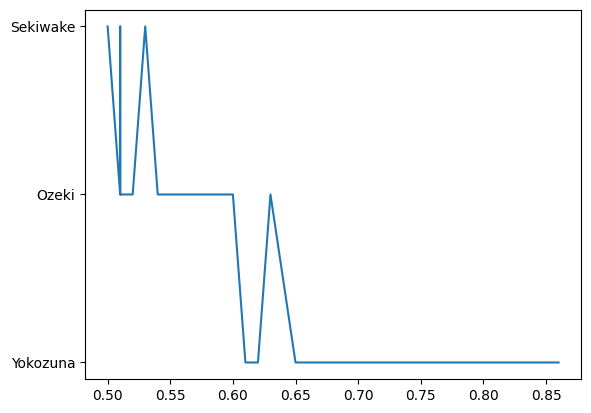

In [31]:
plt.plot(with_500_wins["pct"], with_500_wins["top_rank"])

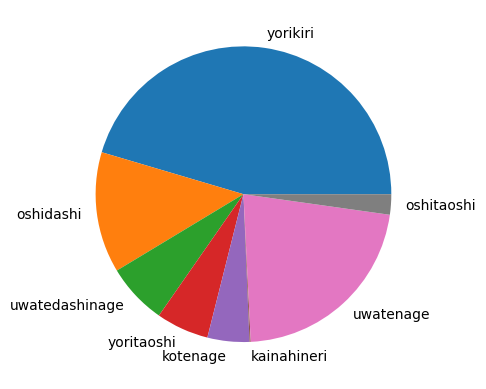

In [32]:
# This doesn't yet have all possible kimarite!
hakuho_kimarite = [
    kimarite_dict[1123].count("yorikiri"),
    kimarite_dict[1123].count("oshidashi"),
    kimarite_dict[1123].count("uwatedashinage"),
    kimarite_dict[1123].count("yoritaoshi"),
    kimarite_dict[1123].count("kotenage"),
    kimarite_dict[1123].count("kainahineri"),
    kimarite_dict[1123].count("uwatenage"),
    kimarite_dict[1123].count("oshitaoshi")
]
hakuho_kimarite_labels = ["yorikiri", "oshidashi", "uwatedashinage", "yoritaoshi", "kotenage", "kainahineri", "uwatenage", "oshitaoshi"]
plt.pie(hakuho_kimarite, labels = hakuho_kimarite_labels)
plt.show()

In [33]:
#TO DO LIST###############################################

# Ranking Data Dictionary
# Kimarite Data Dictionary

I have already added each wrestler's favored kimarite (finishing move) to the main dataframe, but below I aim to give an overview of all the kimarite that all wrestlers have used in the top division. As you can see, the techniques yorikiri and oshidashi are overwhelming favored, and after the most frequent 12 kimarite, the numbers start to drop off very quickly until the bottom results barely see any usage at all.

In [34]:
total_kimarite_list = []

for i in sumo_only_wins["kimarite"].unique(): #unique to get a total list of all the unique kimarite
    total_kimarite_list.append(i)
total_kimarite_list.sort()

total_kimarite_list_dict = {}

for i in total_kimarite_list:
    total_kimarite_list_dict[i] = len(sumo_only_wins[sumo_only_wins["kimarite"] == i])

total_kimarite_df = pd.DataFrame(total_kimarite_list_dict.items(), columns=["kimarite", "occurances"]).sort_values(by='occurances', ascending=False)
total_kimarite_df

,kimarite,occurances
81,yorikiri,32912
44,oshidashi,22053
9,hatakikomi,8903
76,uwatenage,6543
63,tsukiotoshi,6183
...,...,...
6,gasshohineri,2
66,tsumatori,1
58,tasukizori,1
37,okurigake,1


In what follows, I put the top 12 kimarite (which all have 2700+ occurances; the 13th most frequent kimarite drops all the way down to 1955 occurances) into a dataframe. Then I made a dataframe of the remaining lower-frequency kimarite in order to get their total sum (which happens to be an even 13000). I then make that bottom-frequency total into its own line as the 13th entry in the top-frequency dataframe. Thus, the resulting dataframe shows the 12 most-frequency kimarite with a row for "other," which indicates the sum total of lower-frequency kimarite.

In [35]:
total_kimarite_df_top = total_kimarite_df.loc[total_kimarite_df.occurances >=2700].sort_values(by='occurances', ascending=False).reset_index(drop=True)

total_kimarite_df_bottom = total_kimarite_df.loc[total_kimarite_df.occurances <2700].sort_values(by='occurances', ascending=False).reset_index(drop=True)

total_kimarite_df_bottom.count() # There are 72 of these low-frequency kimarite
sum_of_other_kimarite = sum(total_kimarite_df_bottom['occurances']) # This adds up to exactly 13000

total_kimarite_df_top.loc[len(total_kimarite_df_top.index)] = ['72 others', sum_of_other_kimarite]

# I was going to re-sort this dataframe, but I think the visual is better seeing "other" at the bottom, since "other" represents an assortment of
# lower-used kimarite instead of being a single entity with the third-most occurances

total_kimarite_df_top

,kimarite,occurances
0,yorikiri,32912
1,oshidashi,22053
2,hatakikomi,8903
3,uwatenage,6543
4,tsukiotoshi,6183
5,hikiotoshi,5112
6,yoritaoshi,4394
7,okuridashi,3570
8,oshitaoshi,2968
9,sukuinage,2830


Now to visualize this with a pie chart showing the kimarite frequency. You can easily see how yorikiri and oshidashi dominate the scene. The 72 low-frequency kimarite combined don't even approach those slices. The ten kimarite ranked #3-#12 in frequency all eke out smaller slices of the overall pie.

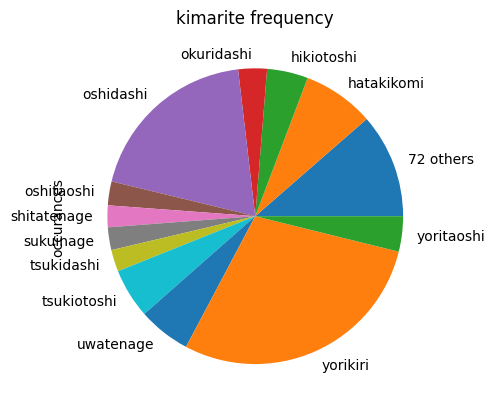

In [36]:
total_kimarite_df_top.groupby(["kimarite"]).sum().plot(kind="pie", y="occurances")
title = plt.title("kimarite frequency")
plt.legend('', frameon=False)

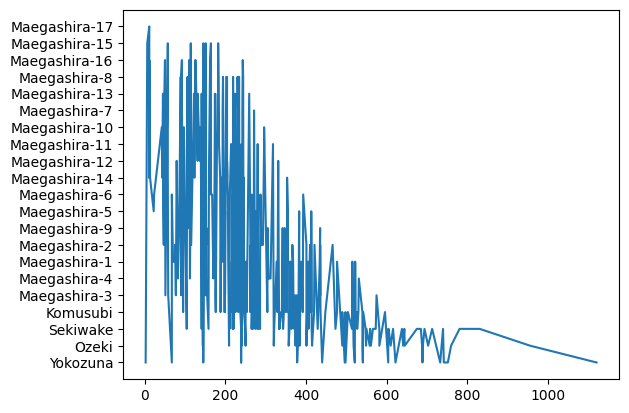

In [37]:
# with_500_wins.groupby(["rikishi"]).sum().plot(kind="pie", y="matches")
# title = plt.title("kimarite frequency")
# plt.legend("", frameon=False)
yokozuna_only = analysis_df.loc[analysis_df.top_rank == "Yokozuna"]
# yokozuna_only.groupby(["favored_kimarite"]).plot(kind="pie", y="favored_kimarite")
# plt.legend("", frameon=False)
# yokozuna_only


xpoints = np.array(makuuchi_only["wins"])
ypoints = np.array(makuuchi_only["top_rank"])
plt.plot(xpoints, ypoints)
plt.show()

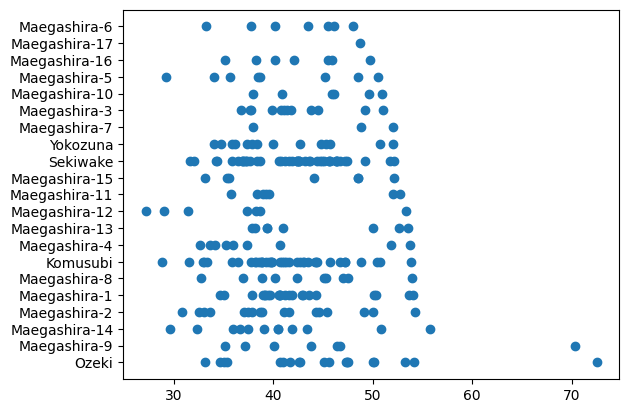

In [38]:
makuuchi_only_with_bmi = makuuchi_only.loc[makuuchi_only.bmi > 0].sort_values(by='bmi', ascending=False).reset_index(drop=True)

xpoints = np.array(makuuchi_only_with_bmi["bmi"])
ypoints = np.array(makuuchi_only_with_bmi["top_rank"])
plt.plot(xpoints, ypoints, "o")
plt.show()
# makuuchi_only_with_bmi

<Axes: xlabel='matches'>

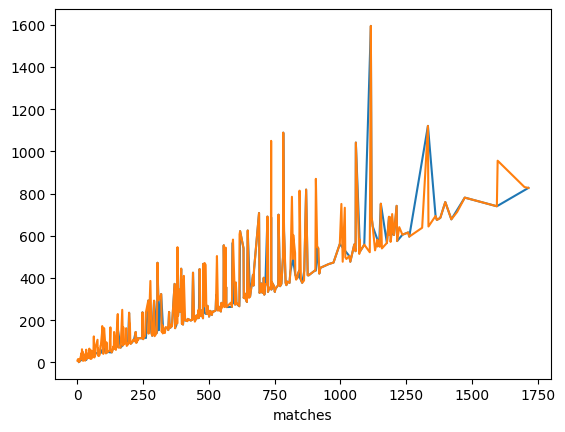

In [39]:
makuuchi_only_with_bmi.groupby(["matches"])["wins"].sum().plot()
analysis_df.groupby(["matches"])["wins"].sum().plot()

<Axes: ylabel='wins'>

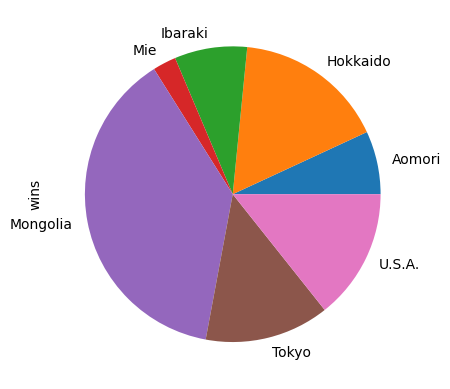

In [40]:
yokozuna_only.groupby(["shusshin"])["wins"].sum().plot(kind="pie")

The way sumo tournaments are set up, usually wrestlers tend to have the most matches against peers of a similar rank. Especially over time, one might imagine that 

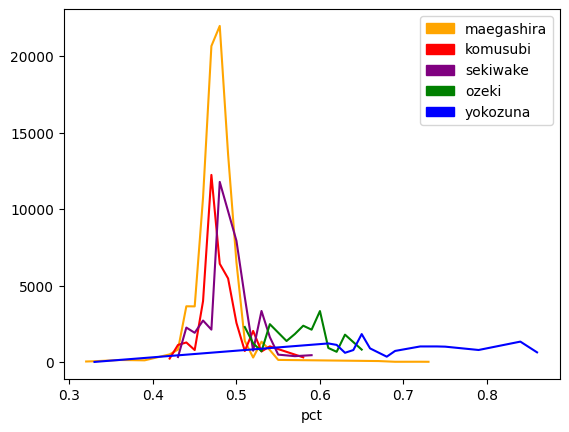

In [41]:
maegashira_only = analysis_df.loc[analysis_df.top_rank.str.startswith("Maegashira")]
komusubi_only = analysis_df.loc[(analysis_df.top_rank == "Komusubi")]
sekiwake_only = analysis_df.loc[(analysis_df.top_rank == "Sekiwake")]
ozeki_only = analysis_df.loc[(analysis_df.top_rank == "Ozeki")]
yokozuna_only = analysis_df.loc[(analysis_df.top_rank == "Yokozuna")]


# maegashira_only.groupby(["pct"])["wins"].sum().plot(color="orange")
maegashira_only.groupby(["pct"])["matches"].sum().plot(color="orange")
komusubi_only.groupby(["pct"])["matches"].sum().plot(color="red")
sekiwake_only.groupby(["pct"])["matches"].sum().plot(color="purple")
ozeki_only.groupby(["pct"])["matches"].sum().plot(color="green")
yokozuna_only.groupby(["pct"])["matches"].sum().plot(color="blue")

maegashira_patch = mpatches.Patch(color="orange", label="maegashira")
komusubi_patch = mpatches.Patch(color="red", label="komusubi")
sekiwake_patch = mpatches.Patch(color="purple", label="sekiwake")
ozeki_patch = mpatches.Patch(color="green", label="ozeki")
yokozuna_patch = mpatches.Patch(color="blue", label="yokozuna")
plt.legend(handles=[maegashira_patch, komusubi_patch, sekiwake_patch, ozeki_patch, yokozuna_patch])

# Success by Highest Rank Achieved
Having established each wrestler's highest-achieved rank, this scatter plot provides a visualization of how total wins and overall winning percentage compares at these ranks. I will limit the data here to only the wrestlers actually ranked in the top Makuuchi division (excluding the lower-ranked wrestlers who may have found themselves competing in that top division on occasion). We might imagine that, due to wrestlers often being paired against opponents of a similar strength, most wrestlers end up roughly around a 50% winning percentage. That holds true here, though the more elite ranks (the #2 rank of Ozeki and the #1 rank of Yokozuna) are clear outliers. To achieve and maintain these ranks, a wrestler has to be consistently strong. (Although Yokozuna-ranked wrestlers can never be demoted, they tend to retire if they begin to lose too often.) The next-highest ranks, Sekiwake and Komusubi, are closer to 50% in winning percentage, though they are often not too different from the hgihest ranks in terms of total victories. To make it to these levels, wrestlers are strong enough to generally have lengthy careers, building up plenty of wins even if they don't make it to the absolute pinnacle of the ranks. Finally, we have the rank-and-file top-division wrestlers, Maegashira-1 through Maegashira-10, who hover around a 50% victory rate and sometimes show some longevity in accruing wins, and, predictably bringing up the rear, the have the lower-ranked Maegashira (Maegashira-11 and below), who do not tend to rack up nearly as many victories in their careers.

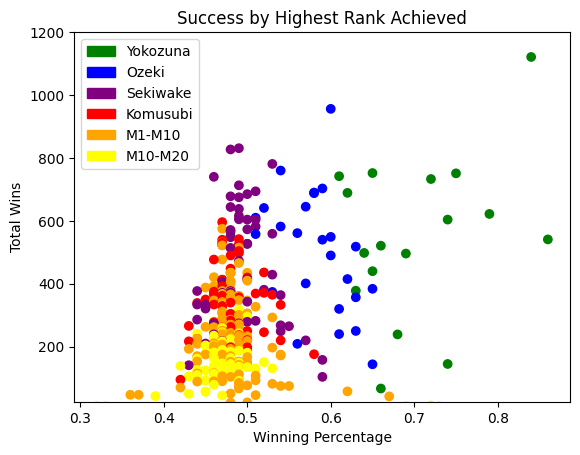

In [269]:
# Creating a dataset to only include wrestlers at Maegashira ranks and above
makuuchi_only = analysis_df.loc[
    (analysis_df.top_rank == "Yokozuna")
    | (analysis_df.top_rank == "Ozeki")
    | (analysis_df.top_rank == "Sekiwake")
    | (analysis_df.top_rank == "Komusubi")
    | (analysis_df.top_rank.str.startswith("Maegashira"))
]

fit, ax = plt.subplots()
ax.scatter(
    makuuchi_only["pct"],
    makuuchi_only["wins"],
    c=makuuchi_only["top_rank"].map(
        {
            "Yokozuna": "green",
            "Ozeki": "blue",
            "Sekiwake": "purple",
            "Komusubi": "red",
            "Maegashira-1": "orange",
            "Maegashira-2": "orange",
            "Maegashira-3": "orange",
            "Maegashira-4": "orange",
            "Maegashira-5": "orange",
            "Maegashira-6": "orange",
            "Maegashira-7": "orange",
            "Maegashira-8": "orange",
            "Maegashira-9": "orange",
            "Maegashira-10": "orange",
            "Maegashira-11": "yellow",
            "Maegashira-12": "yellow",
            "Maegashira-13": "yellow",
            "Maegashira-14": "yellow",
            "Maegashira-15": "yellow",
            "Maegashira-16": "yellow",
            "Maegashira-17": "yellow",
            "Maegashira-18": "yellow",
            "Maegashira-19": "yellow",
            "Maegashira-20": "yellow",
        }
    ),
)

maegashira_patch1 = mpatches.Patch(color="yellow", label="M10-M20")
maegashira_patch2 = mpatches.Patch(color="orange", label="M1-M10")
komusubi_patch = mpatches.Patch(color="red", label="Komusubi")
sekiwake_patch = mpatches.Patch(color="purple", label="Sekiwake")
ozeki_patch = mpatches.Patch(color="blue", label="Ozeki")
yokozuna_patch = mpatches.Patch(color="green", label="Yokozuna")

plt.legend(handles=[yokozuna_patch, ozeki_patch, sekiwake_patch, komusubi_patch, maegashira_patch2, maegashira_patch1,], loc="upper left")

# Cutting off the bottom outliers with less than 25 wins. They could be wrestlers who only briefly competed in the top ranks or
# wrestlers at either the beginning or ending of their careers during the 1983-2023 period this project covers.

plt.ylim([25, 1200])

plt.xlabel("Winning Percentage")
plt.ylabel("Total Wins")
plt.title("Success by Highest Rank Achieved")
plt.show()

<Axes: xlabel='height'>

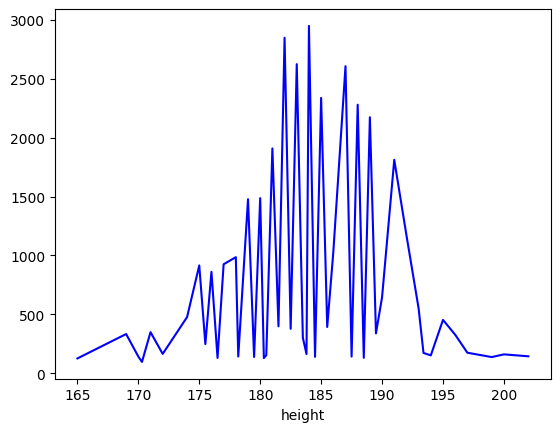

In [119]:
maegashira_only = analysis_df.loc[analysis_df.top_rank.str.startswith("Maegashira")]
komusubi_only = analysis_df.loc[(analysis_df.top_rank == "Komusubi")]
sekiwake_only = analysis_df.loc[(analysis_df.top_rank == "Sekiwake")]
ozeki_only = analysis_df.loc[(analysis_df.top_rank == "Ozeki")]
yokozuna_only = analysis_df.loc[(analysis_df.top_rank == "Yokozuna")]


makuuchi_only_with_bmi
# maegashira_only.groupby(["pct"])["matches"].sum().plot(color="orange")
# komusubi_only.groupby(["pct"])["matches"].sum().plot(color="red")
# sekiwake_only.groupby(["pct"])["matches"].sum().plot(color="purple")
# ozeki_only.groupby(["pct"])["matches"].sum().plot(color="green")
# yokozuna_only.groupby(["pct"])["matches"].sum().plot(color="blue")
# analysis_df.groupby(["height"])["wins"].sum().plot(color="blue")
makuuchi_only_with_bmi.groupby(["height"])["avg_weight"].sum().plot(color="blue")
# makuuchi_only_with_bmi.groupby(["bmi"]).plot()
# maegashira_patch = mpatches.Patch(color="orange", label="maegashira")
# komusubi_patch = mpatches.Patch(color="red", label="komusubi")
# sekiwake_patch = mpatches.Patch(color="purple", label="sekiwake")
# ozeki_patch = mpatches.Patch(color="green", label="ozeki")
# yokozuna_patch = mpatches.Patch(color="blue", label="yokozuna")
# plt.legend(handles=[maegashira_patch, komusubi_patch, sekiwake_patch, ozeki_patch, yokozuna_patch])

# plt.xlim([75, 250])

# Most Successful Heya

A *heya*, or  stable, is where sumo wrestlers live and train. It functions a bit like a team might in other sports. Usually wrestlers from the same heya don't fight each other in a tournament unless there are special circumstances, like a tiebreaker for a championship. This bar chart examines the most successful heya of the studied time period. We can see the number of wrestlers in a heya to achieve a top-division ranking (*makuuchi*) shown in green, followed by the number of wrestlers who have reached the elite titleholder (*san'yaku*) ranks in blue. The few numbers in red represent the number of top-ranked *yokozuna* wrestlers. The pattern becomes fairly clear when viewing this chart; the stables that produce the most top-ranked wrestlers also tend to produce the most titleholders, and from the top of that group a handful have also developed wrestlers who have reached the elite rank of yokozuna. 

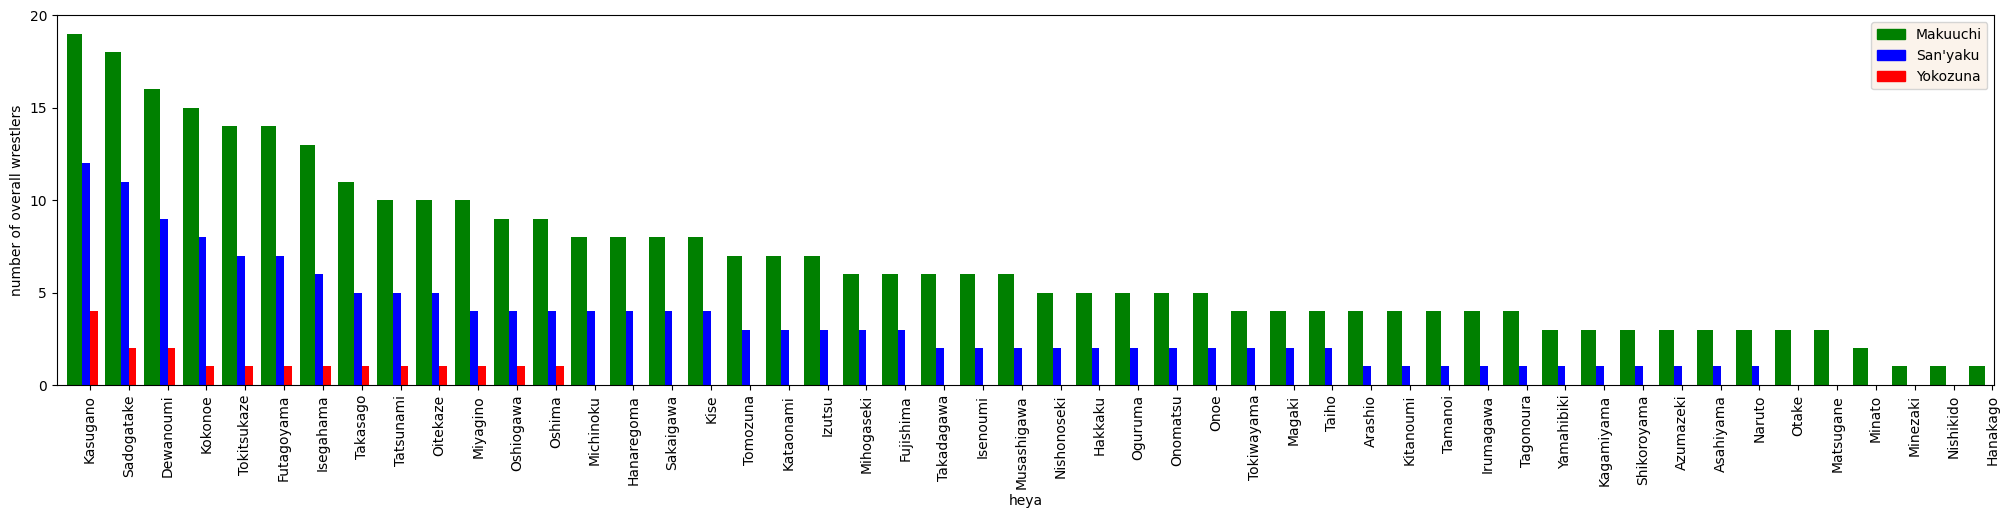

In [274]:
#Re-using the makuuchi_only dataframe, I now create dataframes for the sanyaku_only ranks and for the yokozuna_only rank.

sanyaku_only = analysis_df.loc[
    (analysis_df.top_rank == "Yokozuna")
    | (analysis_df.top_rank == "Ozeki")
    | (analysis_df.top_rank == "Sekiwake")
    | (analysis_df.top_rank == "Komusubi")
]

yokozuna_only = analysis_df.loc[(analysis_df.top_rank == "Yokozuna")]

plt.figure().set_figwidth(25)
yokozuna_only["heya"].value_counts()[:50].plot(color="red", kind="bar", width=.4, align='edge', position=1)
sanyaku_only["heya"].value_counts()[:50].plot(color="blue", kind="bar", width=.4, align='edge', position=1.5)
makuuchi_only["heya"].value_counts()[:50].plot(color="green", kind="bar", width=.4, align='edge', position=2)
plt.ylim([0, 20])
plt.locator_params(axis="y", integer=True)

yokozuna_patch = mpatches.Patch(color="red", label="Yokozuna")
sanyaku_patch = mpatches.Patch(color="blue", label="San'yaku")
makuuchi_patch = mpatches.Patch(color="green", label="Makuuchi")

plt.legend(facecolor="linen", handles=[makuuchi_patch, sanyaku_patch, yokozuna_patch], loc="upper right")
plt.ylabel("number of overall wrestlers")
plt.show()

ValueError: could not convert string to float: 'Mongolia'

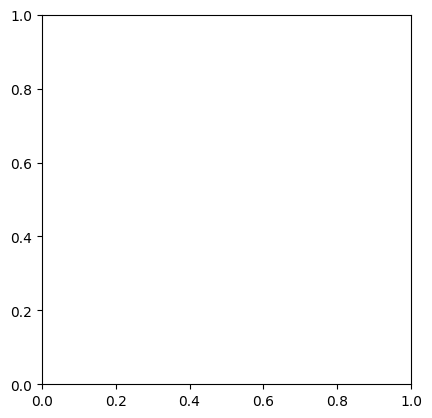

In [204]:
plt.pie(yokozuna_only["shusshin"])


<!-- TO DO: re-do all those win/loss things, but with ID instead of Shikona -->